In [1]:
import sys
sys.path.insert(0, '/tf/utils/')

In [2]:
import numpy as np
import os
# Definir o nível de log do TensorFlow para ERROR
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback
from utils import performance, calculate_stft_magnitude_and_phase, reconstruct_signal_from_stft
from data_generators import NoisyTargetGenerator
from artigos.AttentionResUnet import AttentionResUnet

import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.signal import stft, istft
import librosa
from datetime import datetime
from IPython import display

2024-06-12 16:41:48.184639: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 16:41:48.184678: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 16:41:48.185816: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from sound import Sound

In [4]:
base_shape_size = 8192
ws = 255
ol = 128
NORM_FACTOR = 128
input_shape = (128, 64, 1)

In [ ]:
sound_base_train = Sound('/tf/Dados/Vozes/train/', '/tf/Dados/Ruido/train/', base_shape_size)
sound_base_val = Sound('/tf/Dados/Vozes/val/', '/tf/Dados/Ruido/val/', base_shape_size)

Loading Noise Files:   0%|          | 0/1627 [00:00<?, ?it/s]]

In [ ]:
data_generator_train = NoisyTargetGenerator(sound_base_train.clean_sounds, sound_base_train.noise_sounds)
data_generator_val = NoisyTargetGenerator(sound_base_val.clean_sounds, sound_base_val.noise_sounds, add_white=False)

In [ ]:
# model = AttentionResUnet(input_shape).get_model()
# model = load_model('checkpoint-2024-04-21_04-20-09.h5')

In [ ]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=False, show_layer_names=False)

In [ ]:
# model.summary()

In [ ]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = AttentionResUnet(input_shape).get_model()
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0009))

In [ ]:
def weighted_msle(y_true, y_pred):
    # Define o peso para penalizar mais as subestimações
    w = 2.0

    # Evita valores negativos adicionando 1 antes de aplicar o log
    log_true = 20 * tf.math.log(y_true + 1)
    log_pred = 20 * tf.math.log(y_pred + 1)

    # Cálculo do erro
    error = log_true - log_pred

    # Aplica pesos diferentes para superestimação e subestimação
    weighted_error = tf.where(error > 0, w * error, error)

    # Retorna a média do erro logarítmico quadrado ponderado
    return tf.reduce_mean(tf.abs(weighted_error))

In [ ]:
# model.compile(loss=weighted_msle, optimizer=Adam(learning_rate=9e-05, epsilon=1e-08))
# model.compile(loss='msle', optimizer=Adam(learning_rate=0.0009))
# model.compile(loss='mse', optimizer=Adam(learning_rate=0.0009))

In [ ]:
def generate_images(model, test_input, tar):
    
    prediction = model(test_input, training=True)
    plt.figure(figsize=(22, 7))
    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Log Power Spectrum - Som ruidoso', 'Log Power Spectrum - Som original', 'Log Power Spectrum - Som filtrado']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(10 * np.log10((display_list[i][..., 0])**2), aspect='auto', cmap='inferno')
        plt.colorbar(format='%+2.0f dB')  # Removi a variável 'im' e 'axs[0]'
        plt.axis('off')
    
    plt.show()

In [ ]:
class GenerateImagesCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_val, y_val):
        self.x_val = x_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        indice_aleatorio = np.random.choice(self.x_val.shape[0])
        amostra_noisy_module = self.x_val[indice_aleatorio][np.newaxis, ...]
        amostra_original_module = self.y_val[indice_aleatorio][np.newaxis, ...]
        generate_images(self.model, amostra_noisy_module, amostra_original_module)

In [ ]:
class PlotLossesCallback(tf.keras.callbacks.Callback):
    def __init__(self, plot_freq):
        super(PlotLossesCallback, self).__init__()
        self.plot_freq = plot_freq
        self.losses = []
        self.fig, self.ax = None, None

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        if loss:
            self.losses.append(loss)
            if (batch + 1) % self.plot_freq == 0:
                self.plot_losses(batch)

    def plot_losses(self, batch):
        if self.fig == None and self.ax == None:
            self.fig, self.ax = plt.subplots(figsize=(10, 4))
        self.ax.clear()
        self.ax.plot(self.losses, '-o')  # Linha com marcadores circulares

        # Adicionando um data label para o último ponto
        if self.losses:
            last_loss = self.losses[-1]
            self.ax.text(len(self.losses) - 1, last_loss, f'{last_loss:.4f}', fontsize=9, verticalalignment='bottom')

        self.ax.set_title(f"Losses up to batch {batch+1}")
        self.ax.set_xlabel("Batch")
        self.ax.set_ylabel("Loss")
        self.fig.canvas.draw()

In [ ]:
# Gera um novo lote de validação para cada época
validation_batch = next(data_generator_val.generate_sample_completo(batch_size=32, only_return_mudule=True))
x_val, y_val = validation_batch

In [ ]:
best_models_path = "./AttentionResUnet_checkpoints/"
callbacks_lst = [
    tf.keras.callbacks.ModelCheckpoint(filepath=best_models_path+"mirror_attention_res_unet_custom-mlse.h5", save_freq=100, save_weights_only=False),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.0000009, min_delta=0.0001, factor=0.70, patience=3, verbose=1, mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.0001, patience=20),
    GenerateImagesCallback(x_val, y_val),
    PlotLossesCallback(plot_freq=20)
]

In [ ]:
steps_per_epoch_train = len(sound_base_train.clean_sounds)
steps_per_epoch_validation = len(sound_base_val.clean_sounds)

batch_size = 16
steps_per_epoch = len(sound_base_train.clean_sounds) // batch_size
epochs = 60

val_data = next(data_generator_val.generate_sample_completo(batch_size=4 * batch_size, include_clean=True, only_return_mudule=True))

model.fit(data_generator_train.generate_sample_completo(batch_size=batch_size, include_clean=True, only_return_mudule=True),
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          validation_data=val_data,
          callbacks=callbacks_lst
         )

In [20]:
# Defina sua função de criação de gráfico com base nos dados de validação
def create_plot(x_val, y_val, model):
    F_f = model.predict(x_val, verbose=False)

    indice_aleatorio = np.random.choice(x_val.shape[0])
    x_test = x_val[indice_aleatorio]
    f_test = F_f[indice_aleatorio]
    y_test = y_val[indice_aleatorio]

    A = y_test[:, :, 0]
    phi = (y_test[:, :, 1] - 0.5) * 2 * np.pi
    
    A_f = f_test[:, :, 0]
    phi_f = (f_test[:, :, 1] - 0.5) * 2 * np.pi
    
    A_n = x_test[:, :, 0]
    phi_n = (x_test[:, :, 1] - 0.5) * 2 * np.pi

    s = reconstruct_signal_from_stft(A, phi)
    s_n = reconstruct_signal_from_stft(A_n, phi_n)
    s_f = reconstruct_signal_from_stft(A_f, phi_f)

    display.clear_output(wait=True)

    # Criando figuras e eixos separados para cada array
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    
    # Plotando o primeiro array
    ax1.plot(s)
    ax1.set_ylabel('Sinal de voz ruidoso')
    
    # Plotando o primeiro array
    ax2.plot(s_n)
    ax2.set_ylabel('Sinal de voz ruidoso')
    
    ax3.plot(s_f)
    ax3.set_ylabel('Sinal de voz filtrado')
    
    # Exibindo os gráficos
    plt.show()

    # display_s = Audio(data=s, rate=8000)
    Audio(data=s, rate=8000)
    # display(display_s)
    # display_n = Audio(data=s_n, rate=8000)
    # display(display_n)
    # display_f = Audio(data=s_f, rate=8000)
    # display(display_f)
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Uma linha com três subplots

    # Primeiro gráfico
    im = axs[0].imshow(10*np.log10(A**2), aspect='auto', cmap='inferno')
    axs[0].set_title('Log Power Spectrum - Som original')
    axs[0].set_xlabel('Tempo (s)')
    axs[0].set_ylabel('Frequência (Hz)')
    fig.colorbar(im, ax=axs[0], format='%+2.0f dB')
    
    # Segundo gráfico
    im = axs[1].imshow(10*np.log10(A_n**2), aspect='auto', cmap='inferno')
    axs[1].set_title('Log Power Spectrum - Som ruidoso')
    axs[1].set_xlabel('Tempo (s)')
    axs[1].set_ylabel('Frequência (Hz)')
    fig.colorbar(im, ax=axs[1], format='%+2.0f dB')
    
    # Terceiro gráfico
    im = axs[2].imshow(10*np.log10(A_f**2), aspect='auto', cmap='inferno')
    axs[2].set_title('Log Power Spectrum - Sinal filtrado')
    axs[2].set_xlabel('Tempo (s)')
    axs[2].set_ylabel('Frequência (Hz)')
    fig.colorbar(im, ax=axs[2], format='%+2.0f dB')
    
    plt.tight_layout()  # Para evitar sobreposição de rótulos e gráficos
    plt.show()

# Defina uma classe de callback personalizada para criar o gráfico a cada época
class CreatePlotCallback(Callback):
    def __init__(self, x_val, y_val, model):
        self.x_val = x_val
        self.y_val = y_val
        self.model = model

    def on_epoch_end(self, epoch, logs=None):
        create_plot(self.x_val, self.y_val, self.model)

In [21]:
x_val, y_val = next(data_generator_val.generate_sample_completo(batch_size=24))
plot_callback = CreatePlotCallback(x_val, y_val, model)

In [22]:
batch_size = 64
steps_per_epoch = len(sound_base.train_X) // batch_size

print('Starting training')

for epoch in range(150):
    print(f"Epoch {epoch + 1}")
    
    # Gera um novo lote de validação para cada época
    validation_batch = next(data_generator_val.generate_sample_completo(batch_size=batch_size))
    x_val, y_val = validation_batch
    
    model.fit(data_generator_train.generate_sample_completo(batch_size=batch_size, include_clean=True
                                                           
                                                           ),
                     steps_per_epoch=steps_per_epoch,
                     epochs=1,
                     validation_data=(x_val, y_val),
                     # callbacks=[plot_callback]
                    )
    create_plot(x_val, y_val, model)

NameError: name 'sound_base' is not defined

In [23]:
x_test, y_test = next(data_generator_val.generate_sample_completo(batch_size=8))

In [24]:
x = x_test[..., 0]
x = x[..., np.newaxis]
F_f = model.predict(x)

1/1 [==============================] - 3s 3s/step


In [25]:
A = y_test[0].reshape(y_test.shape[1], y_test.shape[2], y_test.shape[3])[:, :, 0]
phi = (y_test[0].reshape(y_test.shape[1], y_test.shape[2], y_test.shape[3])[:, :, 1] - 0.5) * 2 * np.pi

A_n = x_test[0].reshape(x_test.shape[1], x_test.shape[2], x_test.shape[3])[:, :, 0]
phi_n = (x_test[0].reshape(x_test.shape[1], x_test.shape[2], x_test.shape[3])[:, :, 1] - 0.5) * 2 * np.pi

A_f = F_f[0].reshape(F_f.shape[1], F_f.shape[2], F_f.shape[3])[:, :, 0]
phi_f = phi_n

/tmp/ipykernel_338/1572431701.py:18: RuntimeWarning: divide by zero encountered in log10
  im = axs[2].imshow(10*np.log10(A_f), aspect='auto', cmap='inferno')


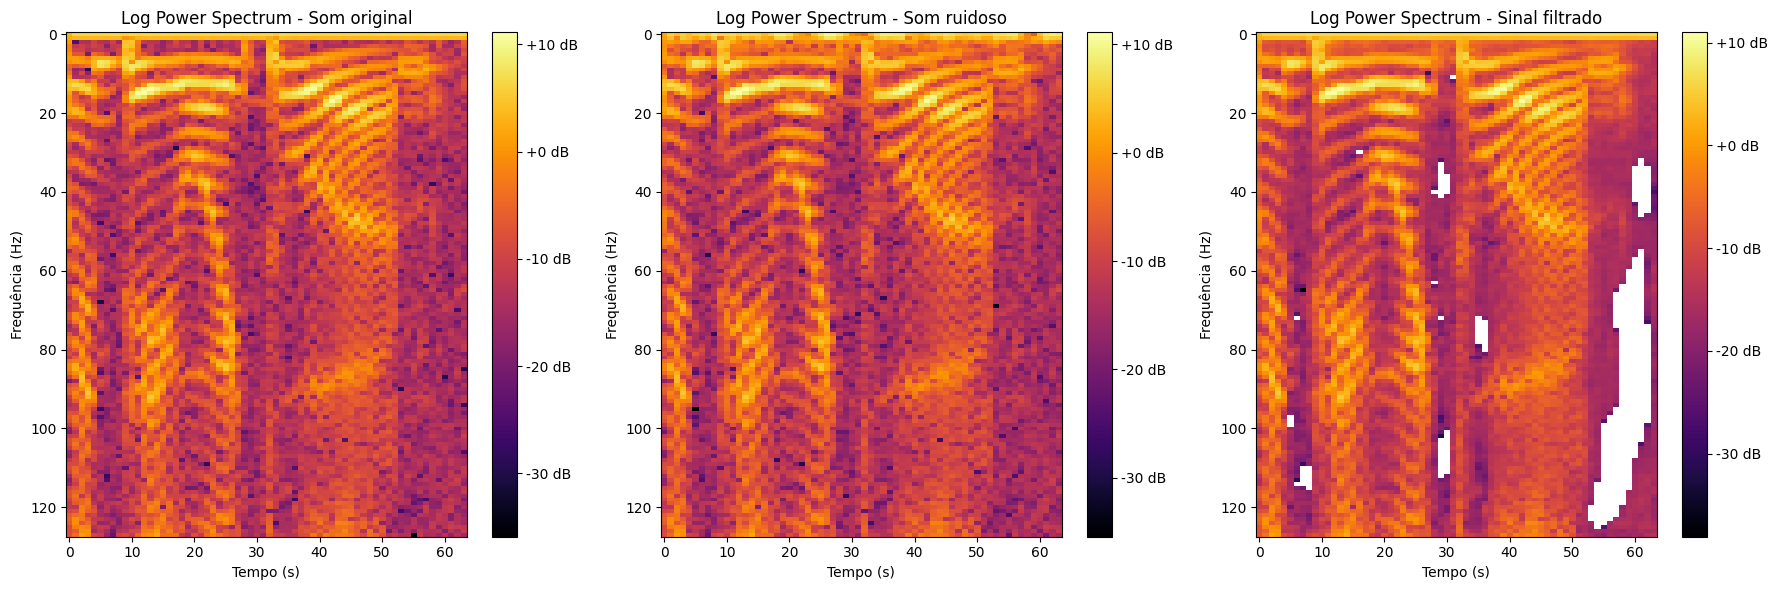

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Uma linha com três subplots

# Primeiro gráfico
im = axs[0].imshow(10*np.log10(A), aspect='auto', cmap='inferno')
axs[0].set_title('Log Power Spectrum - Som original')
axs[0].set_xlabel('Tempo (s)')
axs[0].set_ylabel('Frequência (Hz)')
fig.colorbar(im, ax=axs[0], format='%+2.0f dB')

# Segundo gráfico
im = axs[1].imshow(10*np.log10(A_n), aspect='auto', cmap='inferno')
axs[1].set_title('Log Power Spectrum - Som ruidoso')
axs[1].set_xlabel('Tempo (s)')
axs[1].set_ylabel('Frequência (Hz)')
fig.colorbar(im, ax=axs[1], format='%+2.0f dB')

# Terceiro gráfico
im = axs[2].imshow(10*np.log10(A_f), aspect='auto', cmap='inferno')
axs[2].set_title('Log Power Spectrum - Sinal filtrado')
axs[2].set_xlabel('Tempo (s)')
axs[2].set_ylabel('Frequência (Hz)')
fig.colorbar(im, ax=axs[2], format='%+2.0f dB')

plt.tight_layout()  # Para evitar sobreposição de rótulos e gráficos
plt.show()

In [27]:
A.shape

(128, 64)

In [28]:
# spec = 35

# plt.figure(figsize=(12, 6))

# # Primeiro gráfico (A_n)
# plt.subplot(1, 2, 1)
# plt.plot(10*np.log10(A[:, spec]))
# plt.title('Log Power Spectrum de A')
# plt.xlabel('Amostra')
# plt.ylabel('Potência (dB)')
# plt.ylim(10*np.log10(1e-3), 10*np.log10(8))  # Defina os limites y para ambos os gráficos
# plt.grid(True)

# # Segundo gráfico (A)
# plt.subplot(1, 2, 2)
# plt.plot(10*np.log10(A_n[:, spec]))
# plt.title('Log Power Spectrum de A_n')
# plt.xlabel('Amostra')
# plt.ylabel('Potência (dB)')
# plt.ylim(10*np.log10(1e-3), 10*np.log10(8))  # Use os mesmos limites y definidos anteriormente
# plt.grid(True)

# plt.tight_layout()

# plt.show()

In [29]:
s = reconstruct_signal_from_stft(A, phi)
s_n = reconstruct_signal_from_stft(A_n, phi_n)
s_f = reconstruct_signal_from_stft(A_f, phi_f)

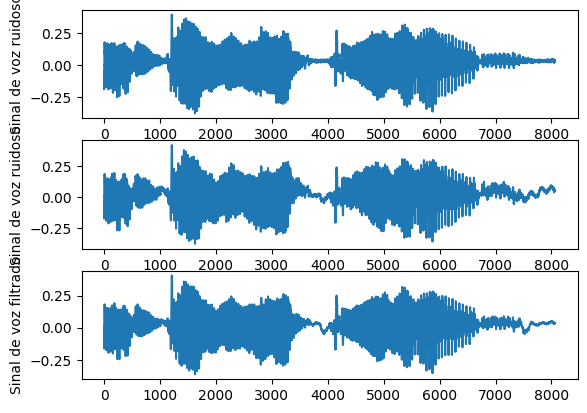

In [30]:
# Criando figuras e eixos separados para cada array
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

# Plotando o primeiro array
ax1.plot(s)
ax1.set_ylabel('Sinal de voz ruidoso')

# Plotando o primeiro array
ax2.plot(s_n)
ax2.set_ylabel('Sinal de voz ruidoso')

ax3.plot(s_f)
ax3.set_ylabel('Sinal de voz filtrado')

# Exibindo os gráficos
plt.show()

In [31]:
Audio(data=s, rate=8000)

In [32]:
Audio(data=s_n, rate=8000)

In [33]:
Audio(data=s_f, rate=8000)

In [33]:
# Get the current datetime
current_datetime = datetime.now()

# Format the datetime as a string to use in the file name
datetime_str = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

model.save('att-res-unet-loss-0.5484-epochs-41-'+datetime_str+'.h5')